In [ ]:
"""
Visualization

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in
a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets.
The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual
concepts.  Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won’t
survey all of them, but we’ll cover three of the most accessible and useful ones:

1. Visualizing intermediate convnet outputs (intermediate activations) — Useful for understanding how successive convnet layers transform
   their input, and for getting a first idea of the meaning of individual convnet filters.

2. Visualizing convnets filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.

3. Visualizing heatmaps of class activation in an image—Useful for understanding which parts of an image were identified as belonging to
   a given class, thus allowing you to localize objects in images.
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

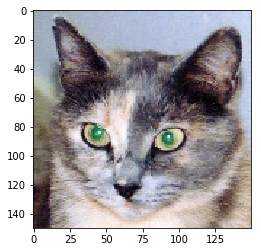

In [4]:
"""
Visualizing intermediate activations (1)

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers
in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function).
This gives a view into how an input is decomposed into the different filters learned by the network. You want to visualize feature maps
with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to
visualize these feature maps is by independently plotting the contents of every channel as a 2D image. 
"""
from keras.models import load_model
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np

# model reminder
model = load_model('./model/cats_and_dogs_small_2.h5')
print(model.summary())

# get a picture of a cat
img_path = './data/small_cat_dog/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

# display the picture
plt.imshow(img_tensor[0])
plt.show()

(1, 148, 148, 32)


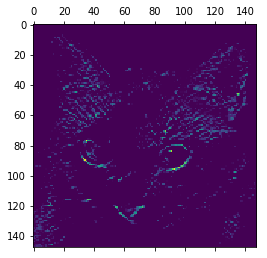

In [12]:
"""
Visualizing intermediate activations (2)

1. In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and
   outputs the activations of all convolution and pooling layers. To do this, you’ll use the Keras class Model. A model is instantiated
   using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class
   is a Keras model, just like the Sequential models, mapping the specified inputs to the specified outputs. What sets the Model class
   apart is that it allows for models with multiple outputs, unlike Sequential.

2. When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you’ve
   encountered a multi-output model: until now, the models you’ve seen have had exactly one input and one output. In the general case,
   a model can have any number of inputs and outputs. This one has one input and eight outputs: one output per layer activation.
"""
from keras import models
from keras import layers

# extract the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]

# create a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

# the actication of first convolution layer for cat image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# 4th channel
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis') 

/data/home/zhangmu/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


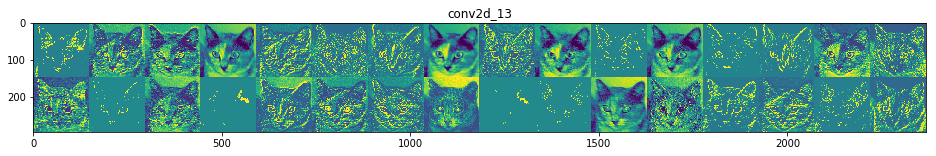

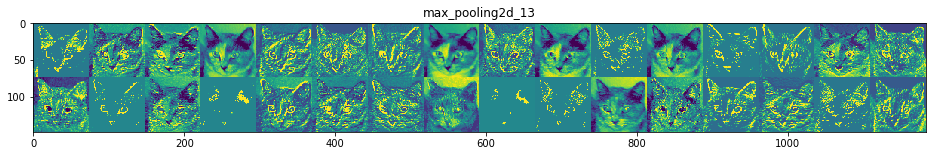

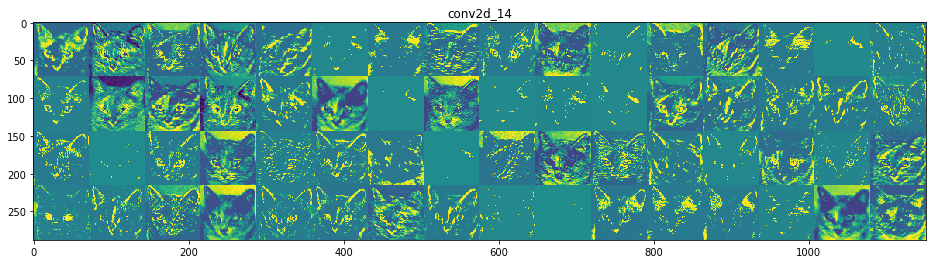

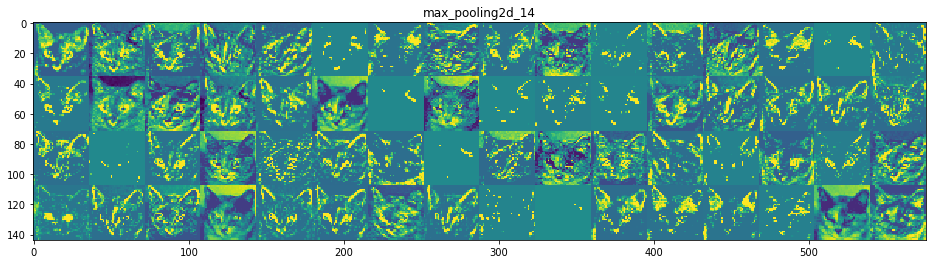

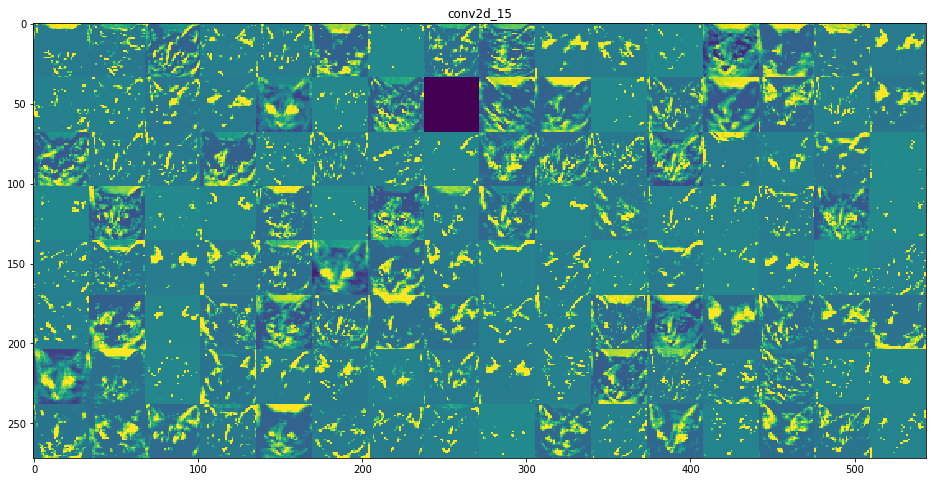

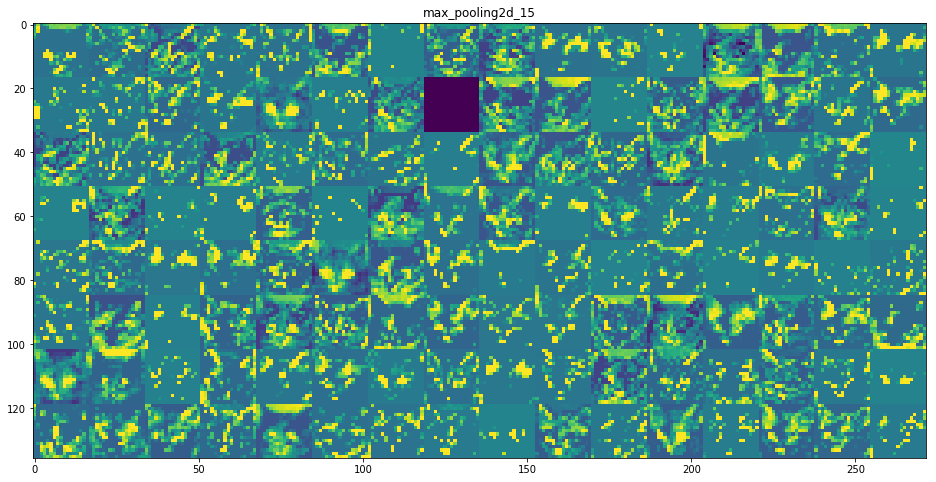

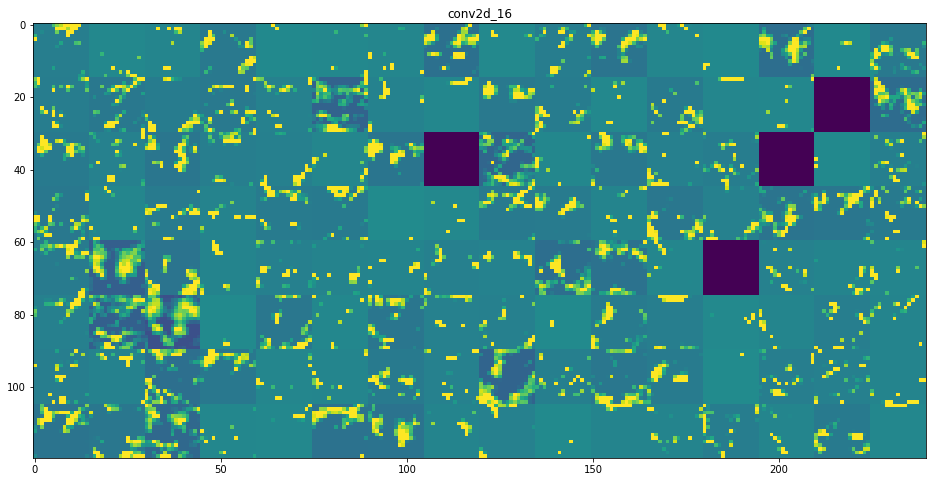

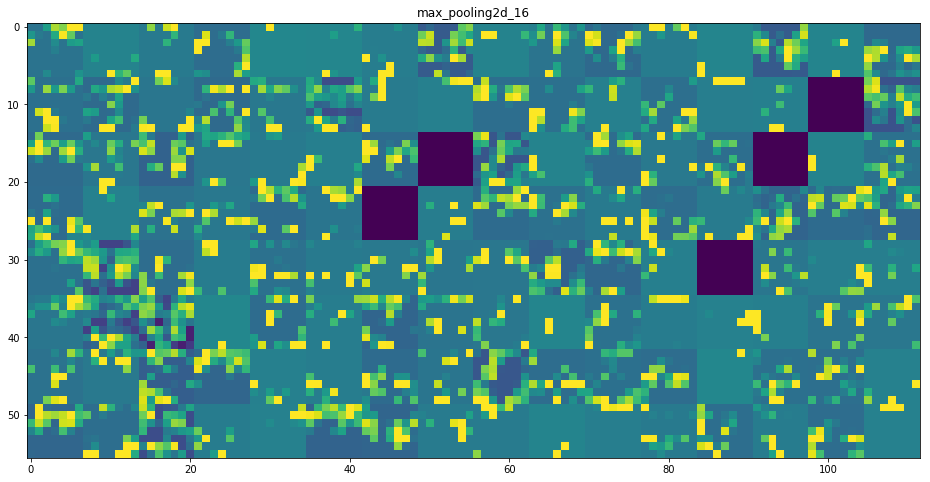

In [10]:
"""
Visualizing intermediate activations (3)

1. Few things to note:
   -- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information
      present in the initial picture.
   -- As go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts
      such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image,
      and increasingly more information related to the class of the image.
   -- The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input
      image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in
      the input image.

2. An important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become
   increasingly abstract with the depth of the layer. The activations of higher layers carry less and less information about the specific
   input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural
   network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being
   repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and
   useful information is magnified and refined (for example, the class of the image).
"""
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')